# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import time
import glob
import PIL
import pickle
from datetime import datetime
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.layers import * 
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from scipy.ndimage import gaussian_filter
from IPython import display

In [2]:
from phosphenes import *

Using TensorFlow backend.


# Grid Parameters

In [3]:
gridType= DistortedPolarGrid
gridParam1 = 12
gridParam2 = 12
gridVectorLength = gridParam1 * gridParam2
renderSize1 = 48
renderSize2 = 48

# Initial MNIST Data

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

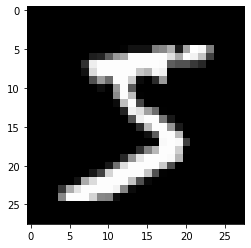

In [5]:
plt.imshow(train_images[0], cmap='gray')

In [6]:
num_real, original_y, original_x = train_images.shape

In [7]:
def process_images(images):
    
    # Upscale only to 80% of the render, to leave some padding around the digit
    up_x, up_y = int(renderSize1 * (3/4)), int(renderSize2 * (3/4))
    pad_y = (renderSize1 - up_y) // 2
    pad_x = (renderSize2 - up_x) // 2
    pad_widths = ((pad_y, pad_y), (pad_x, pad_x))

    processed = np.array([
        np.roll(
            
            # Pad and resize up to the render dimensions
            np.pad(
                cv2.resize(
                    image, 
                    dsize=(up_y, up_x)
                ), 
                pad_widths,
                'constant',
                constant_values=0
            ),
            
            # Shift along the X-axis to the right
            shift=(renderSize2 // 5),
            axis=1,
            
        )
        for image in train_images
    ])
    
    # Scale the values from 0-255 to -1-1
    processed = (processed - 127.5) / 127.5
    
    return processed

In [8]:
train_images = process_images(train_images)

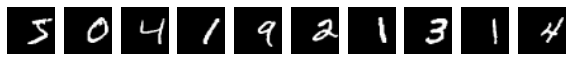

In [9]:
fig, ax = plt.subplots(1, 10, figsize=(10,1))

for i in range(10):
    ax[i].imshow(train_images[i], cmap='gray')
    ax[i].axis('off')

In [10]:
@tf.function
def gauss2d(sigma, truncate=3.0):
    radius = tf.cast(sigma * truncate, tf.int32)
    x = tf.cast(tf.range(-radius, radius + 1), tf.float32)
    k = tf.exp(-0.5 * tf.square(x / sigma))
    k = k / tf.reduce_sum(k)
    return tf.expand_dims(k, 1) * k

In [11]:
@tf.function
def add_dropout(images):
    
    min_dropout_unit = 3
    max_dropout_unit = 6
    num_dropout_unit = max_dropout_unit - min_dropout_unit + 1

    
    unit_divisor = tf.random.uniform((1,), min_dropout_unit, max_dropout_unit, tf.int32)[0]
    kernel_width = tf.random.uniform((1,), 2, 4, tf.float32)[0]
    kernel = tf.expand_dims(gauss2d(kernel_width), -1)

    # Create a batch of random masks
    mask = tf.random.uniform((len(images),
                              renderSize1 // unit_divisor,
                              renderSize2 // unit_divisor),
                              minval=0,
                              maxval=2,
                              dtype=tf.int32)
    mask = tf.dtypes.cast(mask, tf.float32)

    # Expand the dimensions of the mask 
    expanded = tf.expand_dims(mask, -1)
    resized = tf.image.resize(expanded, (renderSize1, renderSize2))
    squeezed = tf.squeeze(resized)

    # Rescale image if source is -1 to 1
    rescaled = (images + 1) / 2

    # Masked
    masked = rescaled * squeezed

    # Blurred
    blurred = tf.nn.conv2d(tf.expand_dims(masked, -1),
                           tf.expand_dims(kernel, -1),
                           strides=[1,1,1,1],
                           padding='SAME')

    blurred = tf.squeeze(blurred)

    # Scale back to between -1 and 1
    maxval = tf.reduce_max(blurred)
    minval = tf.reduce_min(blurred)

    return (((blurred - minval) / maxval) * 2) - 1
        

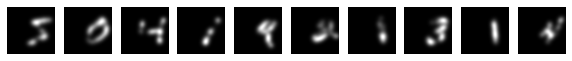

In [12]:
train_images_slice = add_dropout(tf.cast(train_images[:10], tf.float32))

fig, ax = plt.subplots(1, 10, figsize=(10,1))

for i in range(10):
    ax[i].imshow(train_images_slice[i], cmap='gray')
    ax[i].axis('off')

# Encoder

Based loosely on the network architecture described in https://arxiv.org/pdf/1703.10593.pdf Appendix 7.2.

In [13]:
def make_encoder():

    # Input noise
    in_image = Input(shape=(renderSize1, renderSize2))
    
    # Layers
    l_image  = Reshape((renderSize1, renderSize2, 1))(in_image)
    
    l_image  = Conv2D(64, (7,7), strides=(1,1), padding='same')(l_image)
    l_image  = BatchNormalization()(l_image)
    l_image  = LeakyReLU()(l_image)
    
    l_image  = Conv2D(128, (3,3), strides=(2,2), padding='same')(l_image)
    l_image  = BatchNormalization()(l_image)
    l_image  = LeakyReLU()(l_image)    

    l_image  = Conv2D(256, (3,3), strides=(1,1), padding='same')(l_image)
    l_image  = BatchNormalization()(l_image)
    l_image  = LeakyReLU()(l_image)
    
    l_image  = Conv2D(256, (3,3), strides=(1,1), padding='same')(l_image)
    l_image  = BatchNormalization()(l_image)
    l_image  = LeakyReLU()(l_image)
    
    l_image  = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(l_image)
    l_image  = BatchNormalization()(l_image)
    l_image  = LeakyReLU()(l_image)
    
    l_image  = Conv2DTranspose(1, (3,3), strides=(1,1), padding='same', activation="tanh")(l_image)
    l_image  = Reshape((renderSize1, renderSize2))(l_image)
    
    model    = Model([in_image], l_image)
    
    return model

In [14]:
encoder = make_encoder()

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [16]:
def encoder_loss(decoded_fake):
    loss = cross_entropy(tf.ones_like(decoded_fake), decoded_fake)
    return loss

In [17]:
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Decoder

In [18]:
def make_decoder():
    
    # Image input
    in_image = Input(shape=(renderSize1, renderSize2))
    l_image  = Reshape((renderSize1, renderSize2, 1))(in_image)
    
    # Convolution
    l_image  = Conv2D(64, (4,4), padding='same', strides=(2,2))(l_image)
    l_image  = BatchNormalization()(l_image)
    l_image  = LeakyReLU()(l_image)
    
    l_image  = Conv2D(128, (4,4), padding='same', strides=(2,2))(l_image)
    l_image  = BatchNormalization()(l_image)
    l_image  = LeakyReLU()(l_image)
    
    l_image  = Flatten()(l_image)
    l_image  = Dense(1, activation=tf.nn.sigmoid)(l_image)
    
    # Model 
    model         = Model([in_image], l_image)
    
    return model    

In [19]:
decoder = make_decoder()

In [20]:
def decoder_loss(decoded_real, decoded_fake):
        
    real_loss = cross_entropy(tf.ones_like(decoded_real), decoded_real)
    fake_loss = cross_entropy(tf.zeros_like(decoded_fake), decoded_fake)
    loss = real_loss + fake_loss
    
    return loss

In [21]:
decoder_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Data Storage

In [22]:
save_dir = "./data/training-hole-filling/"
base     = "{dir}/{time}_{type}_{renderSize1}_{renderSize2}.{ext}"
now      = datetime.now().strftime('%Y-%m-%d_%H-%M')

In [23]:
common_format = {
    'time': now,
    'renderSize1': renderSize1,
    'renderSize2': renderSize2,
}

In [24]:
loss_filepath = save_dir + base.format(
    dir="training-losses",
    type='loss',
    ext='log',
    **common_format
)

gif_filepath = save_dir + base.format(
    dir="training-gifs",
    type='evolution',
    ext='gif',
    **common_format
)

encoder_filepath = save_dir + base.format(
    dir='training-encoders',
    type='encoder',
    ext='h5',
    **common_format
)

# Training

In [25]:
@tf.function
def train_step(real_images, dropout_images):
    
    with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape:
        
        fake_images  = encoder(dropout_images, training=True)
        decoded_real = decoder(real_images)
        decoded_fake = decoder(fake_images)
        
        enc_loss = encoder_loss(decoded_fake)
        dec_loss = decoder_loss(decoded_real, decoded_fake)

    # Output the losses to the log files
    tf.print(enc_loss, output_stream=enc_logfile)
    tf.print(dec_loss, output_stream=dec_logfile)
    
    # Calculate and apply the gradients to the encoder and decoder
    gradients_of_encoder = enc_tape.gradient(enc_loss, encoder.trainable_variables)
    gradients_of_decoder = dec_tape.gradient(dec_loss, decoder.trainable_variables)

    encoder_optimizer.apply_gradients(zip(gradients_of_encoder, encoder.trainable_variables))
    decoder_optimizer.apply_gradients(zip(gradients_of_decoder, decoder.trainable_variables))

In [26]:
image_directory = "./data/training-hole-filling/training-images/"

In [27]:
display_images = train_images_slice

In [28]:
def generate_and_save_images(encoder, epoch):
    
    encodings = encoder(display_images, training=False)
    
    fig, ax = plt.subplots(1, 10, figsize=(10,1))

    for i in range(10):
        ax[i].imshow(encodings[i].numpy(), cmap='gray', vmin=-1, vmax=1)
        ax[i].axis('off')
        
    plt.suptitle(f"Epoch {epoch}")

    plt.savefig(image_directory + 'generated-epoch-{0:02d}.png'.format(epoch))
    plt.show()

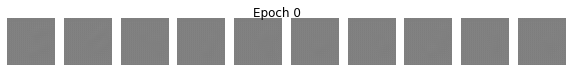

In [29]:
generate_and_save_images(encoder, 0)

In [30]:
BATCH_SIZE = 250
EPOCH_SIZE = num_real
NUM_BATCHES = EPOCH_SIZE // BATCH_SIZE

In [31]:
NUM_BATCHES

240

In [32]:
# Define the encoder and decoder log paths
enc_logpath = loss_filepath.replace("_loss_", "_enc_loss_cgan_")
dec_logpath = loss_filepath.replace("_loss_", "_dec_loss_cgan_")

# Format for tensorflow's print function
enc_logfile = "file://" + enc_logpath
dec_logfile = "file://" + dec_logpath

In [33]:
initial_fake_images = encoder(add_dropout(tf.cast(train_images[:BATCH_SIZE], tf.float32)))

In [34]:
initial_decoded_fake = decoder(initial_fake_images)

In [35]:
initial_decoded_real = decoder(tf.cast(train_images[:BATCH_SIZE], tf.float32))

In [36]:
with open(enc_logpath, 'w') as outfile:
    encoder_loss_value = encoder_loss(initial_decoded_fake)
    outfile.write(str(encoder_loss_value.numpy()))
    outfile.write('\n')
    
with open(dec_logpath, 'w') as outfile:
    decoder_loss_value = decoder_loss(initial_decoded_real, initial_decoded_fake)
    outfile.write(str(decoder_loss_value.numpy()))
    outfile.write('\n')

In [37]:
def train(epochs):
    
    for epoch in range(epochs):
        start = time.time()

        for i in range(NUM_BATCHES):
            imin = i * BATCH_SIZE
            imax = (i+1) * BATCH_SIZE
            
            real_images_slice = tf.cast(train_images[imin:imax], tf.float32)
                    
            # Add dropout to the real images
            dropout_images_slice = add_dropout(real_images_slice)
            
            train_step(real_images_slice, dropout_images_slice)

        # Generate and save progressive images
        display.clear_output(wait=True)
        generate_and_save_images(encoder, epoch + 1)

        print(f'Time for epoch {epoch+1} is {time.time()-start} sec.')

# Running Training

In [38]:
EPOCHS = 50

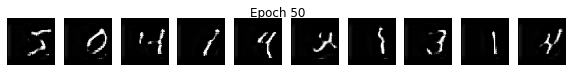

Time for epoch 50 is 3124.8638455867767 sec.


In [39]:
train(EPOCHS)

# Viewing Results

In [73]:
def plot_loss(logpath):
    
    enc_logpath = logpath.replace("_loss_", "_enc_loss_cgan_")
    dec_logpath = logpath.replace("_loss_", "_dec_loss_cgan_")
    
    with open(enc_logpath) as infile:
        enc_loss_raw = infile.readlines()
        
    with open(dec_logpath) as infile:
        dec_loss_raw = infile.readlines()

    enc_loss_data = np.array(list(map(float, enc_loss_raw)))
    dec_loss_data = np.array(list(map(float, dec_loss_raw)))

    plt.plot(range(enc_loss_data.shape[0]), enc_loss_data, color='teal', label='Loss for encoder training')
    plt.plot(range(dec_loss_data.shape[0]), dec_loss_data, color='tomato', label='Loss for decoder training')
    plt.ylabel("Loss")
    plt.xlabel("Training Batch (each containing 250 images)")
    plt.title("Loss per Epoch")
    plt.legend()

    plot_file = logpath.replace("losses", "graphs").replace(".log", ".png")
    plt.savefig(plot_file)
    print("./03-psychophysics/" + plot_file)
    return plot_file

./03-psychophysics/./data/training-hole-filling/training-graphs/2019-07-15_16-47_loss_48_48.png


'./data/training-hole-filling/training-graphs/2019-07-15_16-47_loss_48_48.png'

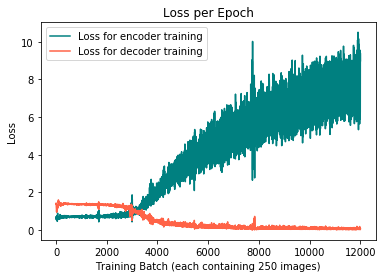

In [74]:
plot_loss(loss_filepath)

In [42]:
generated_images = glob.glob(image_directory + ("*.png"))
images = [PIL.Image.open(image) for image in generated_images]

# save the first image 10 times
images[0].save(gif_filepath,
               save_all=True,
               append_images=[images[0]] * 10 + images + [images[-1]]*10,
               duration=100,
               loop=0)

In [43]:
encoder.save(encoder_filepath)

In [44]:
test = tf.keras.models.load_model(encoder_filepath)

W0717 11:46:28.008492  9544 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


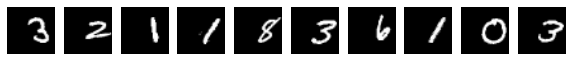

In [77]:
fig, ax = plt.subplots(1, 10, figsize=(10,1))

for i in range(198, 208):
    ax[i-198].imshow(train_images[i], cmap='gray')
    ax[i-198].axis('off')

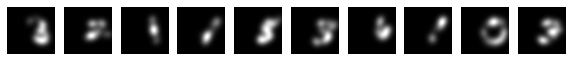

In [59]:
test_slice = add_dropout(tf.cast(train_images[198:208], tf.float32))

fig, ax = plt.subplots(1, 10, figsize=(10,1))

for i in range(10):
    ax[i].imshow(test_slice[i], cmap='gray')
    ax[i].axis('off')

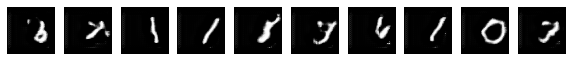

In [70]:
test_renders = test(test_slice)


fig, ax = plt.subplots(1, 10, figsize=(10,1))

for i in range(10):
    ax[i].imshow(test_renders[i], cmap='gray')
    ax[i].axis('off')